# Homework 2
## Application: SVD and PCA for Machine Learning

### Visualizing dyad
##### Consider an image from skimage.data. For simplicity, say that $X ∈ R^{m×n}$ is the matrix representing that image. You are asked to visualize the dyad of the SVD decomposition of $X$ and the result of compressing the image via SVD. In particular:
* Load the image into memory and compute its SVD;
* Visualize some of the dyad $σ_iu_iv_{i}^T$ of this decomposition. What do you notice?
* Plot the singular values of $X$. Do you note something?
* Visualize the k-rank approximation of $X$ for different values of k. What do you observe?
* Compute and plot the approximation error $||X − X_k||F$ for increasing values of k, where $X_k$ is the k-rank approximation of k.
* Plot the compression factor $c_k = 1- \frac{k(m+n+1)}{mn}$ for increasing $k$. What is the approximation error when
the compressed image requires the same amount of informations of those of the uncompressed image (i.e. $c_k = 0$)?

##### 1. Load image in memory and compute SVD

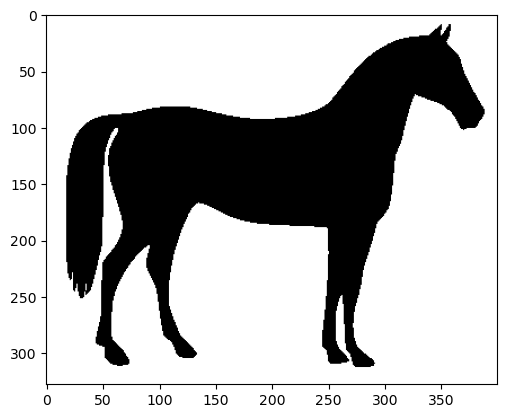

Shape of the image: (328, 400)
Decomposition matrixes shapes: (328, 328) (328,) (400, 400)


In [230]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

#Loading the "cameraman" image
X = skimage.data.horse()
plt.imshow(X, cmap = 'gray')
plt.show()

#print it's shape
print(f'Shape of the image: {X.shape}')

#computing the SVD
U, s, VT = np.linalg.svd(X)
print('Decomposition matrixes shapes:', U.shape, s.shape, VT.shape)

##### 2. Visualize some of the dyad

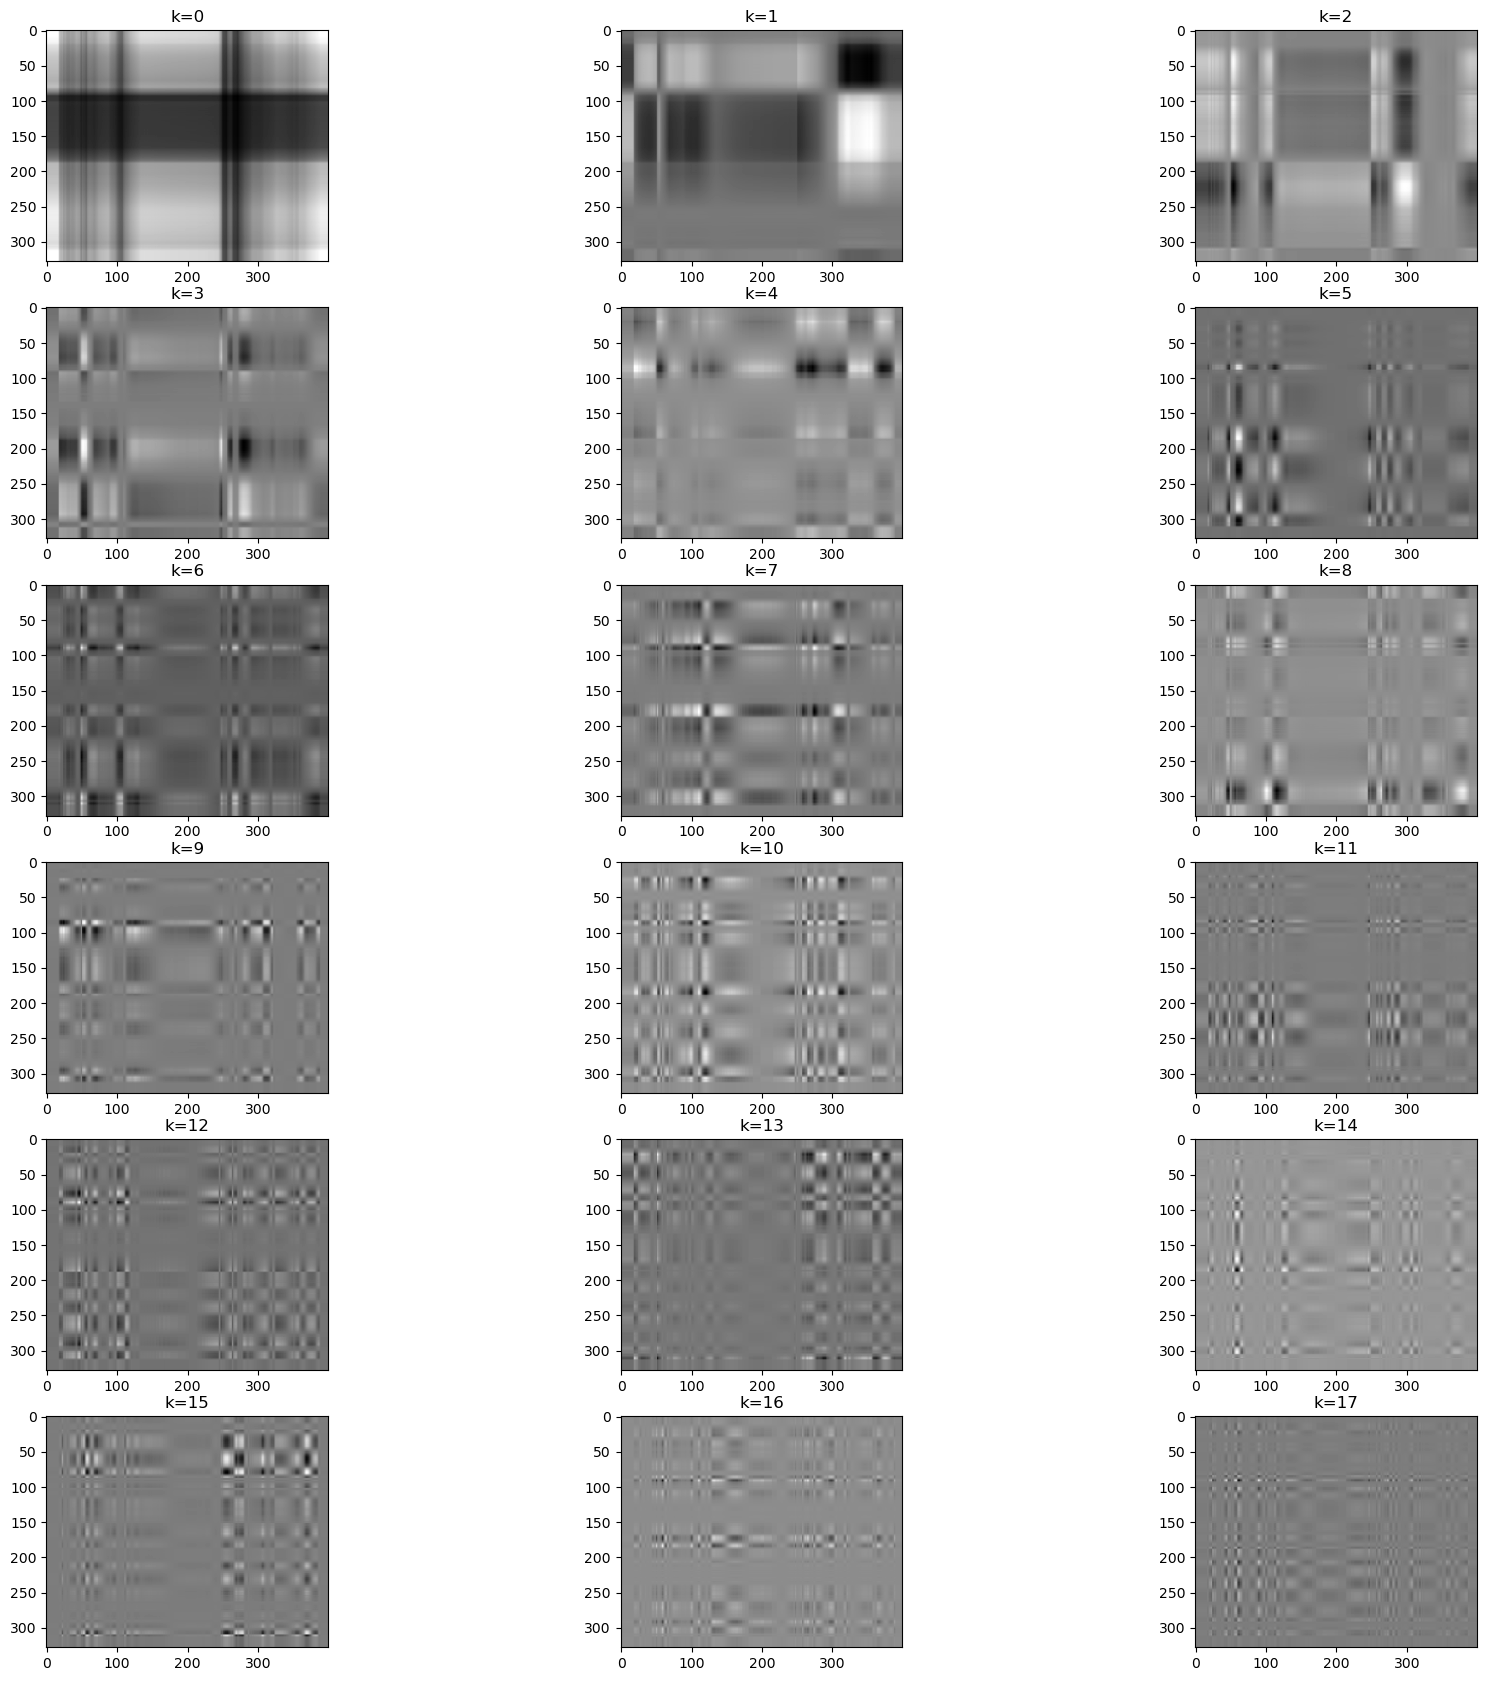

In [231]:
#Each term ui@vit is a rank-1 matrix named dyad
def dyad(U, VT, i):    
    m=U.shape[0]
    n=VT.shape[0]
    
    ui=U[:,i].reshape(m,1)  #reshape the vectors to matrices
    vti=VT[i,:].reshape(1,n)
    Ai = ui@vti
    
    return Ai

plt.figure(figsize=(21, 21))
for k in range(18):
    Ai = dyad(U, VT, k)
    plt.subplot(6, 3, k+1)
    plt.title(f"k={k}")
    plt.imshow(Ai, cmap = 'gray')
plt.show()

We can notice that the variation in the data is lower the farther the dyad we select.


##### 3. Plot the singular values of X

(328,)


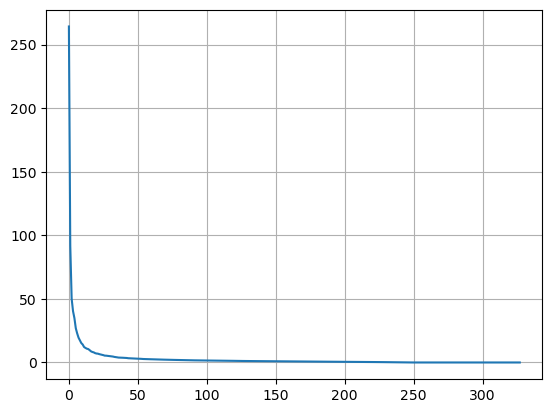

In [232]:
print(s.shape)
plt.plot(s)
plt.grid()
plt.show()

The magnitude of the singular values of $X$ value decreases at each successive $\sigma_i$ 

##### 4. Visualize the k-rank approximation of $X$ for different values of k

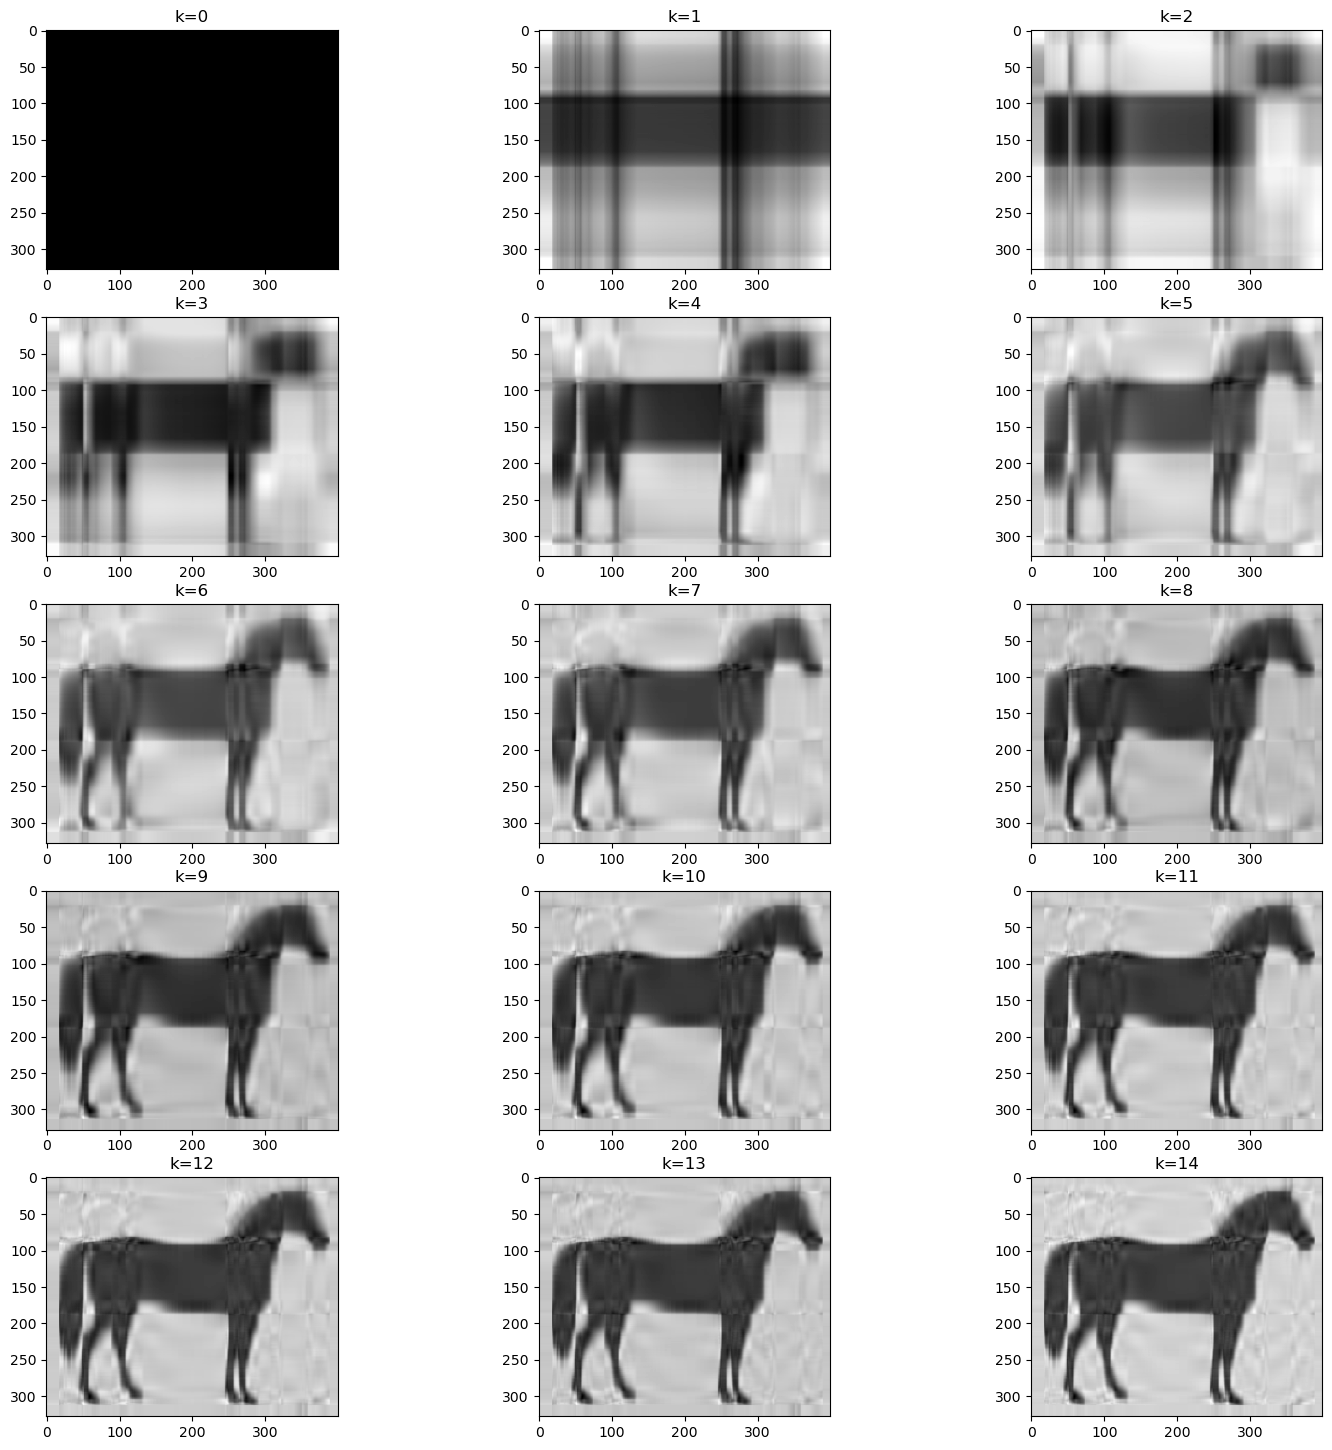

In [233]:
def k_approx(U,s,VT,k):
    m = U.shape[0]
    n = VT.shape[0]
    
    # Get the full S matrix
    S = np.zeros((m, n))
    S[:m, :m] = np.diag(s)                  #Sigma has eigenvalues in the diagonal, rest is filled with zeros
    
    Ak = U[:, :k] @ S[:k, :k] @ VT[:k, :]
    
    return Ak

plt.figure(figsize=(18, 18))
for k in range(15):
    Ak = k_approx(U, s, VT, k)
    plt.subplot(5, 3, k+1)
    plt.title(f"k={k}")
    plt.imshow(Ak, cmap='gray')
plt.show()

The image gets more defined the bigger the number of $k$, but the biggest steps of resolution change are in the first k-rank approximation points, together with the most variability of the data, showed by the singular values magnitude.

##### 5. Compute and plot the approximation error $||X − X_k||$ for increasing values of k, where $X_k$ is the k-rank approximation of $X$.


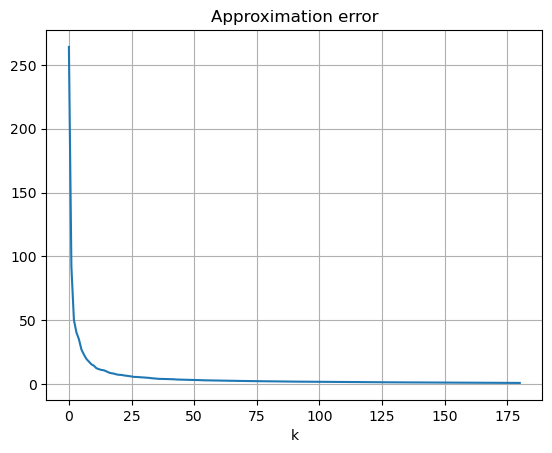

In [234]:
approx_errors = []
for k in range(181):
    Ak = k_approx(U, s, VT, k)
    approx_errors.append( np.linalg.norm( (X - Ak), 2 ) )


plt.plot(approx_errors)
plt.title("Approximation error")
plt.xlabel("k")
plt.grid()
plt.show()

##### 6. Plot the compression factor $ck = 1 − \frac{k(m+n+1)}{mn}$ for increasing k. What is the approximation error when the compressed image requires the same amount of informations of those of the uncompressed image (i.e. ck = 0)?

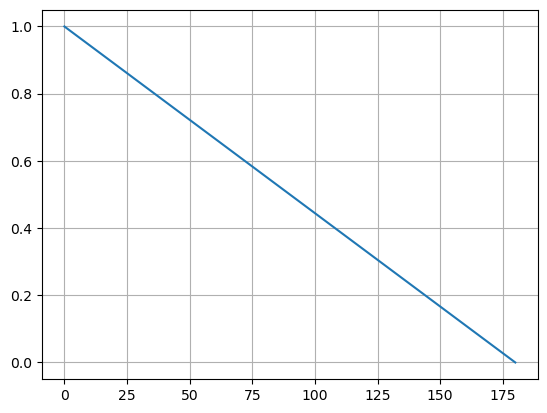

In [235]:
compression_factors = []
for k in range(181):
    compression_factors.append(1 - ( k*(X.shape[0]+X.shape[1]+1) / (X.shape[0]*X.shape[1]) ) )
plt.plot(compression_factors)
plt.grid()
plt.show()

In [236]:
print(f'Aproximation error: {approx_errors[1]} when 1-rank aproximation used (k = 1)')
print(f'Aproximation error: {approx_errors[179]} when compression factor is near 0 (no compression since a lot of information has been used to store decomposition): {compression_factors[179]}')

Aproximation error: 91.69741624110347 when 1-rank aproximation used (k = 1)
Aproximation error: 0.683091200551905 when compression factor is near 0 (no compression since a lot of information has been used to store decomposition): 0.0054039634146341164


When the compressed image requires the same amount of information as the uncompressed image, the approximation error is near zero.

### Classification of MNIST Digits with SVD Decomposition
The task for this exercise is to learn the classification of MNIST digits by using SVD decomposition. Remember that, Given a matrix $X ∈ R^{m×n}$ and its SVD decomposition $X = USV^T$ we can prove that an orthogonal base for the space of the columns is given by the first $p$ columns of the matrix $U$, where $p = rank(X)$ is equal to the number of non-zero singular values of $A$.

We will make use of the space of the columns defined by the $U$ matrix and the following theorem:

**Theorem 1.** *Let’s consider W a subspace of $\mathbb{R}^n$ where $dim \; W = s$ and {$w1, . . . , ws$} an orthogonal base of $W$. Given a generic $y \in \mathbb{R}^n$ we have that the projection $y^{\perp}$ of $y$ onto $W$ has the following form:*

$$ y^\perp = \frac{y\cdot w_1}{w_1\cdot w_1} w_1 + ... + \frac{y\cdot w_s}{w_s\cdot w_s}w_s $$ 

**Corollary 1.1.** *If $X \in \mathbb{R}^{m \times n}$ is a given matrix with SVD decomposition $X = USV^T$, since the $p = rank(X)$ is the dimension of the space defined by the columns of $X$ and the columns of $U$, {$u1, . . . , up$} are an orthonormal basis for that space, the projection of an n-dimensional vector $y$ on this space can be easily computed as:*

$$ y^\perp = U(U^T y) $$

Thus, consider a binary classification problem, where we want to classificate if a given digit of dimension $m × n$ represents the number 3 or the number 4. We will call refer to the class of the number 3 as C1, and to the class of the number 4 as C2. Suppose that s1 is the number of elements in C1, while s2 is the number of elements in C2.
If $X1 ∈ R^{mn×s1}$ is the matrix such that its columns are a flatten version of each digit in C1, $X2 ∈ R^{mn×s2}$ is the matrix such that its columns are a flatten version of each digit in C2, and consider

$$ X_1 = U_1S_1V_1^T $$
$$ X_2 = U_2S_2V_2^T $$

the SVD decomposition of the two matrices.

If $y$ in $\mathbb{R}^{mxn}$ is a new, unknown digit, we can classify it by first flatten it to a vector of $\mathbb{R}^{mn}$, then we can project it to the spaces of $X_0$ and $X_1$ and call them

$$ y_1^\perp = U_1(U_1^T y) $$
$$ y_2^\perp = U_2(U_2^T y) $$

Thus, $y$ will be classified as $C_1$ if $||y − y^⊥_1||_2 < ||y − y^⊥_2|_2$ and vice versa will be classified as $C_2$ if $||y − y^⊥_2||_2 < ||y − y^⊥_1|_2$.

1. In the first exercise, we will implement the binary classification algorithm for the digits 3 and 4 of MNIST following the ideas explained above.
* Load the MNIST dataset contained in ./data/MNIST.mat with the function scipy.io.loadmat. This dataset, which is loaded in the form of a 256×1707 matrix $X$, contains the flattened version of $1707$ $16 × 16$ grayscale handwritten digits. Moreover, from the same file it is possible to load a vector $I$ of length $1707$ such that the i-th element of $I$ is the true digit represented by the i-th image of $X$.
* Visualize a bunch of datapoints of X with the function plt.imshow.
* Extract from $X$ those columns that corresponds to digits 3 or 4. Those digits represents the
classes $C_1$ and $C_2$ defined above.
* Split the obtained dataset in training and testing. From now on, we will only consider the training
set. The test set will be only used at the end of the exercise to test the algorithm.
* Create the matrices $X_1$ and $X_2$ defined above from $X$.
* Compute the SVD decomposition of $X_1$ and $X_2$ with np.linalg.svd(matrix, full matrices=False) and denote the U-part of the two decompositions as $U_1$ and $U_2$.
* Take an unknown digit y from the test set, and compute $y_1^⊥ = U_1(U_1^T y)$ and $y_2^⊥ = U_2(U_2^T y)$.
* Compute the distances $d_1 = ||y − y_1^⊥||_2$ and $d2 = ||y − y_2^⊥||_2$ and classify $y$ to $C_1$ if $d_1 < d_2$ and
to $C_2$ if $d_2 < d_1$.
* Repeat the experiment for different values of $y$ in the test set. Compute the misclassification
number for this algorithm.
* Repeat the experiment for different digits other than 3 or 4. There is a relationship between the visual similarity of the digits and the classification error?
* Comment the obtained results.

##### 1.1 Load the MNIST dataset contained in ./data/MNIST.mat with the function scipy.io.loadmat. This dataset, which is loaded in the form of a 256×1707 matrix $X$, contains the flattened version of $1707$ $16 × 16$ grayscale handwritten digits. Moreover, from the same file it is possible to load a vector $I$ of length $1707$ such that the i-th element of $I$ is the true digit represented by the i-th image of $X$.

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io

np.random.seed(42)

#Load data into memory____________________
data = scipy.io.loadmat('./data/MNIST.mat')
X = data['X']
I = data['I']   #true labels

print(f'Number of pixels (stored in rows): {X.shape[0]}')
print(f'Number of digit samples (stored in columns): {X.shape[1]}')

Number of pixels (stored in rows): 256
Number of digit samples (stored in columns): 1707


##### 1.2 Visualize a bunch of datapoints of X with the function plt.imshow.

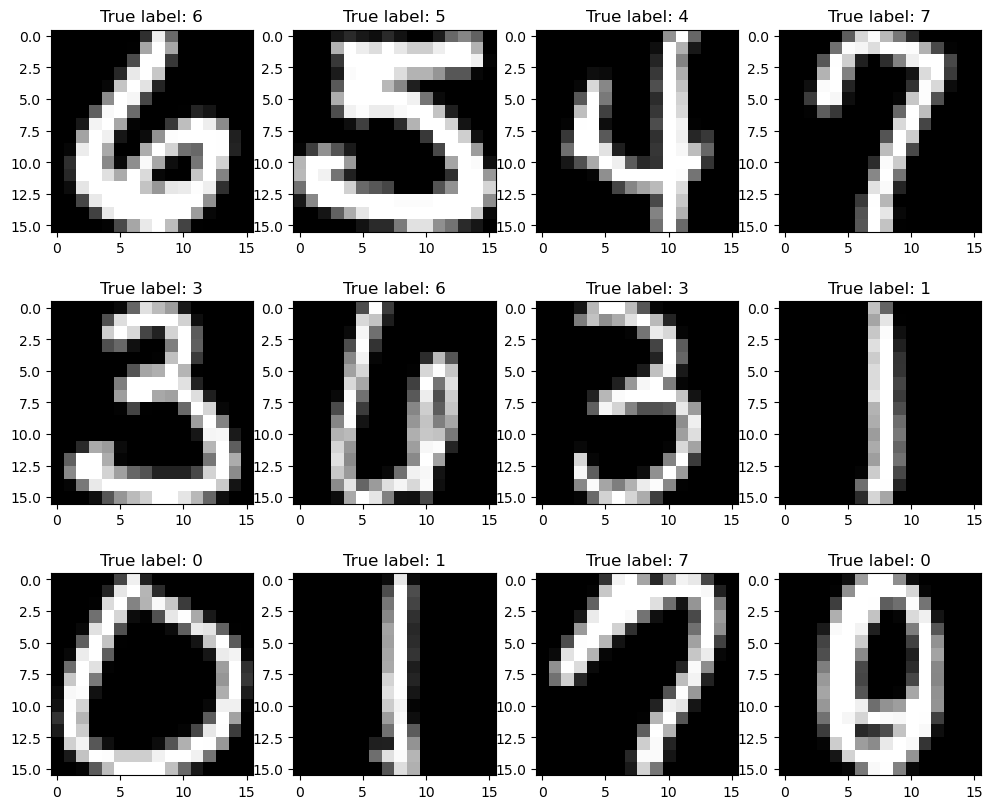

In [238]:
plt.figure(figsize=(12,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.reshape(X[:,i],(16,16)), cmap='gray')
    plt.title(f'True label: {I[0,i]}') #True label


##### 1.3 Extract from $X$ those columns that corresponds to digits 3 or 4. Those digits represents the classes $C_1$ and $C_2$ defined above.

In [239]:
#From the dataset isolate ONLY the datapoints corresponding to the digits 3, 4___
bool_indexes = ( (I[0, :] == 3) | (I[0, :] == 4) )
I = I[:, bool_indexes]
X = X[:, bool_indexes]

print('X shape:', X.shape, ' I shape:', I.shape)
print(f'Number of 3s: {np.sum(I==3)}. Number of 4s: {np.sum(I==4)}')
print('Total number of datapoints:', I.shape[1])

X shape: (256, 253)  I shape: (1, 253)
Number of 3s: 131. Number of 4s: 122
Total number of datapoints: 253


##### 1.4 Split the obtained dataset in training and testing. From now on, we will only consider the training set. The test set will be only used at the end of the exercise to test the algorithm.

In [240]:
#defining function to split the dataset into train and test sets_______
#remembering that the dataset is stored in columns_____________________
def train_test_split(X_, I_, n_train_):
    m, n = X_.shape
    
    indx = np.arange(0, n)                                      #define the array of indexes
    np.random.shuffle(indx)                                     #randomly shuffle the indexes
    
    indx_train = indx[:n_train_]
    indx_test = indx[n_train_:]
    
    X_train, X_test = X_[:, indx_train], X_[:, indx_test]
    
    I_train, I_test = I_[:, indx_train], I_[:, indx_test]
    
    return X_train, X_test, I_train, I_test
    

train_samples = int(X.shape[1]*0.8)
print('Number of train samples:', train_samples)
X_train, X_test, I_train, I_test = train_test_split(X, I, train_samples)
print('X_train shape:', X_train.shape, ' I_train shape:', I_train.shape)

Number of train samples: 202
X_train shape: (256, 202)  I_train shape: (1, 202)


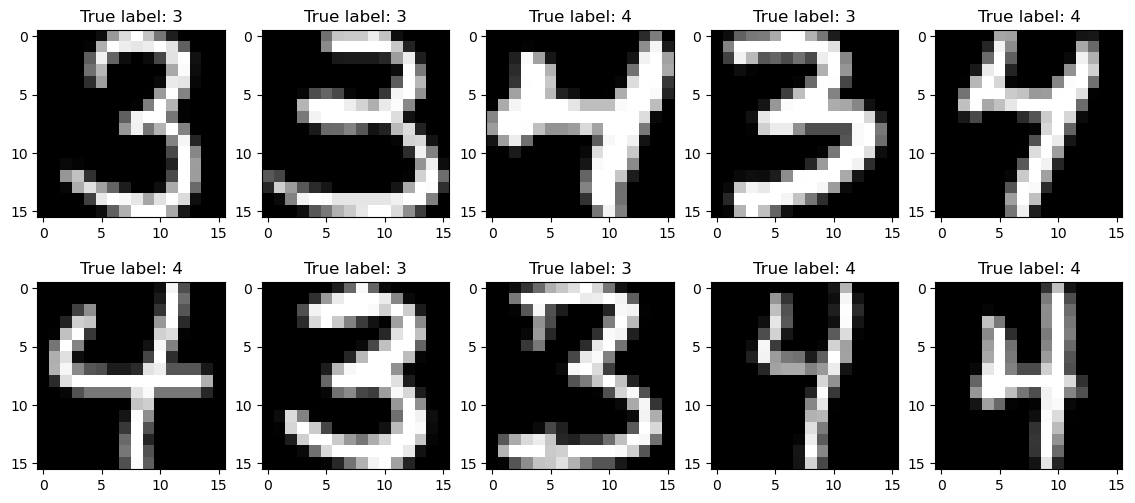

In [241]:
#Test____________________________________________________
#visualing first 10 samples of training set______________
plt.figure(figsize=(14, 6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.reshape(X_train[:,i],(16,16)), cmap='gray')
    plt.title(f'True label: {I_train[0,i]}') #True label

The samples are only 3s and 4s, with the correct labels assigned

##### 1.5 Create the matrices $X_1$ and $X_2$ defined above from X.


In [242]:
X1 = X_train[:, I_train[0,:] == 3]
X2 = X_train[:, I_train[0,:] == 4]
print(f'C1 (3s): {X1.shape[1]} samples, C2 (4s): {X2.shape[1]} samples')

C1 (3s): 106 samples, C2 (4s): 96 samples


##### 1.6 Compute the SVD decomposition of $X_1$ and $X_2$ with np.linalg.svd(matrix, full matrices=False) and denote the U-part of the two decompositions as $U_1$ and $U_2$.

In [243]:
#Compute the compact SVD (full_matrices = False) of the two classes_____
#Only the U matrix is needed for this task______________________________
U1, _, _ = np.linalg.svd(X1, full_matrices=False)
U2, _, _ = np.linalg.svd(X2, full_matrices=False)

##### 1.7 Take an unknown digit $y$ from the $\textbf{test set}$, and compute $y_1^⊥ = U_1(U_1^T y)$ and $y_2^⊥ = U_2(U_2^T y)$.


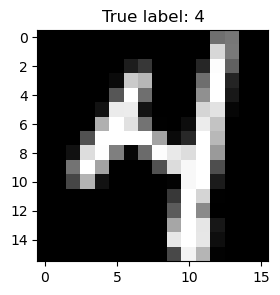

In [244]:

num = np.random.randint(X_test.shape[1])        #random number between 0 and X_test.shape[1]+1 excluded
y = X_test[:, num]                              #y is the test sample 
true_lbl = I_test[0, num]                       #true label of y

plt.figure(figsize=(3, 3))
plt.imshow(np.reshape(y,(16,16)), cmap='gray')
plt.title(f'True label: {true_lbl}')            #True label taken from I_test
plt.show()

y1 = U1@(U1.T@y)                                #computing the projection of y onto the subspace spanned by the 3s
y2 = U2@(U2.T@y)                                #computing the projection of y onto the subspace spanned by the 4s

##### 1.8 Compute the distances $d_1 = ||y − y_1^⊥||_2$ and $d2 = ||y − y_2^⊥||_2$ and classify $y$ to $C_1$ if $d_1 < d_2$ and to $C_2$ if $d_2 < d_1$.

In [245]:
d1 = np.linalg.norm(y-y1, 2)
d2 = np.linalg.norm(y-y2, 2)

#prediction must match the true label from above__
if(d1<d2):
    pred = 3
else:
    pred = 4

print('Predicted: ', pred)
print('True: ', true_lbl)

Predicted:  4
True:  4


##### 1.9 Repeat the experiment for different values of $y$ in the test set. Compute the misclassification number for this algorithm.

The misclassification number can be computed as the misclasified observations as $\frac{1}{n}\Sigma_i(y_i≠\hat{y_i})$. 

In [246]:
n = X_test.shape[1]
predictions_test = np.zeros(n)
for i in range(n):
    y = X_test[:, i]

    y1 = U1@(U1.T@y)
    y2 = U2@(U2.T@y)
    
    d1 = np.linalg.norm(y-y1, 2)
    d2 = np.linalg.norm(y-y2, 2)
    
    if(d1<d2):
        predictions_test[i] = 3
    else:
        predictions_test[i] = 4
        
acc = np.sum((predictions_test==I_test))/I_test.shape[1]
acc_percentage = acc * 100
print('Misclassified samples over testing set:', I_test.shape[1] - np.sum((predictions_test==I_test)))    #total minus correct
print("Accuracy:", round(acc_percentage, 4))

#on training set now_______
n = X_train.shape[1]
predictions_train = np.zeros(n)
for i in range(n):
    y = X_train[:, i]

    y1 = U1@(U1.T@y)
    y2 = U2@(U2.T@y)
    
    d1 = np.linalg.norm(y-y1, 2)
    d2 = np.linalg.norm(y-y2, 2)
    
    if(d1<d2):
        predictions_train[i] = 3
    else:
        predictions_train[i] = 4
        
acc = np.sum((predictions_train==I_train))/I_train.shape[1]
acc_percentage = acc * 100
print('Misclassified samples over training set:', I_train.shape[1] - np.sum((predictions_train==I_train)))    #total minus correct
print("Accuracy:", round(acc_percentage, 4))

Misclassified samples over testing set: 0
Accuracy: 100.0
Misclassified samples over training set: 0
Accuracy: 100.0


##### Computing for different values of k rank aproximation

In [247]:
#computing accuracy for both training set and testing set with different approximation ranks k_________________________________
d = X_train.shape[0]
KS = [1, 2, 3, 4, 5, 10, 20, 30, d]
for k in KS:
    
    count_test = 0
    for i in range(X_test.shape[1]):
        y_test = X_test[:, i]
        true_lbl = I_test[0, i]
        
        Uk1 = U1[:, :k]
        Uk2 = U2[:, :k]
        
        y1 = Uk1@(Uk1.T@y_test)
        y2 = Uk2@(Uk2.T@y_test)
        
        d1 = np.linalg.norm(y_test-y1, 2)
        d2 = np.linalg.norm(y_test-y2, 2)
        
        if(d1<d2):
            pred = 3
        else:
            pred = 4
        
        if(pred == true_lbl):
            count_test += 1
    
    acc_test = count_test / X_test.shape[1]
    
    print(f'Accuracy on testing set for k={k}: {acc_test}, over the digits 3 and 4\n')

Accuracy on testing set for k=1: 0.9803921568627451, over the digits 3 and 4

Accuracy on testing set for k=2: 0.9803921568627451, over the digits 3 and 4

Accuracy on testing set for k=3: 0.9803921568627451, over the digits 3 and 4

Accuracy on testing set for k=4: 1.0, over the digits 3 and 4

Accuracy on testing set for k=5: 1.0, over the digits 3 and 4

Accuracy on testing set for k=10: 1.0, over the digits 3 and 4

Accuracy on testing set for k=20: 1.0, over the digits 3 and 4

Accuracy on testing set for k=30: 1.0, over the digits 3 and 4

Accuracy on testing set for k=256: 1.0, over the digits 3 and 4



##### 1.10 Repeat the experiment for different digits other than 3 or 4. There is a relationship between the visual similarity of the digits and the classification error?
##### 1.11 Comment the obtained results.

In [248]:
def digits_classifier(dig1_, dig2_):
    
    data = scipy.io.loadmat('./data/MNIST.mat')
    X = data['X']
    I = data['I']
    
    #get only the digits we want______________________________
    bool_indexes = ( (I[0, :] == dig1_) | (I[0, :] == dig2_) )
    I = I[:, bool_indexes]
    X = X[:, bool_indexes]
    print('\n\nX shape:', X.shape, ' I shape:', I.shape)
    
    train_samples = int(X.shape[1]*0.8)
    #calling function to split the dataset into train and test sets___
    X_train, X_test, I_train, I_test = train_test_split(X, I, train_samples)
    
    X1 = X_train[:, I_train[0, :] == dig1_]
    X2 = X_train[:, I_train[0, :] == dig2_]
    
    #getting U matrixes for the two classes from the training set_____
    U1, _, _ = np.linalg.svd(X1, full_matrices=False)
    U2, _, _ = np.linalg.svd(X2, full_matrices=False)
    
    n = X_test.shape[1]
    preds = []
    
    for i in range(n):
        y = X_test[:, i]                                                            #selecting digit from test set

        y1 = U1@(U1.T@y)                                                            #computing the projection of y onto the subspace spanned by the 3s
        y2 = U2@(U2.T@y)                                                            #computing the projection of y onto the subspace spanned by the 4s

        d1 = np.linalg.norm(y-y1, 2)                                                #computing the distance between y and the projection onto the subspace spanned by the 3s
        d2 = np.linalg.norm(y-y2, 2)                                                #computing the distance between y and the projection onto the subspace spanned by the 4s
        
        if(d1<d2):
            preds.append(dig1_)
        else:
            preds.append(dig2_)

    print('C1: ', dig1_, ' C2: ', dig2_)
    acc = np.sum((preds==I_test))/I_test.shape[1]
    print('Misclassified samples:', I_test.shape[1] - np.sum((preds==I_test)))      #total minus correct
    print("Accuracy:", round(acc, 6))


#calling classifier for all digits pairs_______
for dig1_ in range(10):
    for dig2_ in range(10):
        if dig1_ != dig2_:
            digits_classifier(dig1_, dig2_)



X shape: (256, 571)  I shape: (1, 571)


C1:  0  C2:  1
Misclassified samples: 0
Accuracy: 1.0


X shape: (256, 521)  I shape: (1, 521)
C1:  0  C2:  2
Misclassified samples: 44
Accuracy: 0.580952


X shape: (256, 450)  I shape: (1, 450)
C1:  0  C2:  3
Misclassified samples: 28
Accuracy: 0.688889


X shape: (256, 441)  I shape: (1, 441)
C1:  0  C2:  4
Misclassified samples: 28
Accuracy: 0.685393


X shape: (256, 407)  I shape: (1, 407)
C1:  0  C2:  5
Misclassified samples: 20
Accuracy: 0.756098


X shape: (256, 470)  I shape: (1, 470)
C1:  0  C2:  6
Misclassified samples: 26
Accuracy: 0.723404


X shape: (256, 485)  I shape: (1, 485)
C1:  0  C2:  7
Misclassified samples: 29
Accuracy: 0.701031


X shape: (256, 463)  I shape: (1, 463)
C1:  0  C2:  8
Misclassified samples: 31
Accuracy: 0.666667


X shape: (256, 451)  I shape: (1, 451)
C1:  0  C2:  9
Misclassified samples: 23
Accuracy: 0.747253


X shape: (256, 571)  I shape: (1, 571)
C1:  1  C2:  0
Misclassified samples: 1
Accuracy: 0.991304


X shape: (256, 454)  I shape: (1, 45

* Considerations: We can notice that the couple (1,7) leads to high mismatch percentages, in fact a lot of number ones "look like" sevens digits. Also the couples (1,8) and (1,9) generate mismatch because many number eights are too sketched
<br>Moreover, many couples with zero (0,-) leads to very high mismatch percentages because, due to its "roundness", zero is similar to nearly all the digits.

##### Retring 1-8 with different k-ranks aproximations to show Overfitting.

In [252]:
data = scipy.io.loadmat('./data/MNIST.mat')
X = data['X']
I = data['I']

#get only the digits we want______________________________
bool_indexes = ( (I[0, :] == 1) | (I[0, :] == 8) )
I = I[:, bool_indexes]
X = X[:, bool_indexes]
print('\n\nX shape:', X.shape, ' I shape:', I.shape)

train_samples = int(X.shape[1]*0.8)
#calling function to split the dataset into train and test sets___
X_train, X_test, I_train, I_test = train_test_split(X, I, train_samples)

X1 = X_train[:, I_train[0, :] == 1]
X2 = X_train[:, I_train[0, :] == 8]

#getting U matrixes for the two classes from the training set_____
U1, _, _ = np.linalg.svd(X1, full_matrices=False)
U2, _, _ = np.linalg.svd(X2, full_matrices=False)

KS = [ 5, 30, 100, X_train.shape[0] ]
for k in KS:
    n = X_test.shape[1]
    Uk1 = U1[:, :k]
    Uk2 = U2[:, :k]
    
    preds = []
    for i in range(n):
        y = X_test[:, i]                                                            #selecting digit from test set
        y1 = Uk1@(Uk1.T@y)                                                          #computing the projection of y onto the subspace spanned by the 3s
        y2 = Uk2@(Uk2.T@y)                                                          #computing the projection of y onto the subspace spanned by the 4s
        d1 = np.linalg.norm(y-y1, 2)                                                #computing the distance between y and the projection onto the subspace spanned by the 3s
        d2 = np.linalg.norm(y-y2, 2)                                                #computing the distance between y and the projection onto the subspace spanned by the 4s
        
        if(d1<d2):
            preds.append(1)
        else:
            preds.append(8)
    print('C1: ', 1, ' C2: ', 8)
    acc = np.sum((preds==I_test))/I_test.shape[1]
    print(f"Accuracy for k:{k}", round(acc, 6))



X shape: (256, 396)  I shape: (1, 396)
C1:  1  C2:  8
Accuracy for k:5 0.9875
C1:  1  C2:  8
Accuracy for k:30 0.9875
C1:  1  C2:  8
Accuracy for k:100 0.9625
C1:  1  C2:  8
Accuracy for k:256 0.8875


##### * We can see that with a higher number of k the accuracy reduces, due to overfitting.

##### **Ex2.** The extension of this idea to the multiple classification task is trivial. Indeed, if we have more than 2 classes (say, k different classes) $C_1, . . . , C_k$, we just need to repeat the same procedure as before for each matrix $X1, . . . , Xk$ to obtain the distances $d_1, . . . , d_k$. Then, the new digit $y$ will be classified as $C_i$ if $d_i$ is lower that $d_j$ for each $j = 1,...,k$.
##### Repeat the exercise above with a 3-digit example. Comment the differences.

In [251]:
def three_digits_classifier(dig1_, dig2_, dig3_):
    
    data = scipy.io.loadmat('./data/MNIST.mat')
    X = data['X']
    I = data['I']
    
    bool_indexes = ( (I[0, :] == dig1_) | (I[0, :] == dig2_) | (I[0, :] == dig3_) )         #get only the digits we want
    I = I[:, bool_indexes]
    X = X[:, bool_indexes]
    print('\n\nX shape:', X.shape, ' I shape:', I.shape)
    
    train_samples = int(X.shape[1]*0.8)                                                     #calling function to split the dataset into train and test sets with 80% of the samples for training
    X_train, X_test, I_train, I_test = train_test_split(X, I, train_samples)                
    
    X1 = X_train[:, I_train[0, :] == dig1_]
    X2 = X_train[:, I_train[0, :] == dig2_]
    X3 = X_train[:, I_train[0, :] == dig3_]
    
    #getting U matrixes for the three classes from the training set_____
    U1, _, _ = np.linalg.svd(X1, full_matrices=False)                                       #getting the orhonormal basis for the subspace spanned by dig1
    U2, _, _ = np.linalg.svd(X2, full_matrices=False)                                       #getting the orhonormal basis for the subspace spanned by dig2
    U3, _, _ = np.linalg.svd(X3, full_matrices=False)                                       #getting the orhonormal basis for the subspace spanned by dig3
    
    n = X_test.shape[1]
    preds = []
    
    for i in range(n):
        #testing test samples with the U1, U2, U3 from the training set____
        y = X_test[:, i]

        y1 = U1@(U1.T@y)
        y2 = U2@(U2.T@y)
        y3 = U3@(U3.T@y)
    
        d1 = np.linalg.norm(y-y1, 2)
        d2 = np.linalg.norm(y-y2, 2)
        d3 = np.linalg.norm(y-y3, 2)
        
        if(d1<d2 and d1<d3):
            preds.append(dig1_)
        elif(d2<d1 and d2<d3):
            preds.append(dig2_)
        elif(d3<d1 and d3<d2):
            preds.append(dig3_)

    print('C1: ', dig1_, ' C2: ', dig2_, ' C3: ', dig3_)
    acc = np.sum((preds==I_test))/I_test.shape[1]
    print('Misclassified samples:', I_test.shape[1] - np.sum((preds==I_test)))    #total minus correct
    print("Accuracy:", round(acc, 6))
    
#calling classifier for three digits______
three_digits_classifier(0, 8, 2)
three_digits_classifier(3, 4, 9)



X shape: (256, 665)  I shape: (1, 665)
C1:  0  C2:  8  C3:  2
Misclassified samples: 77
Accuracy: 0.421053


X shape: (256, 385)  I shape: (1, 385)
C1:  3  C2:  4  C3:  9
Misclassified samples: 4
Accuracy: 0.948052
